In [1]:
import Trader
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import gc
from datetime import datetime

In [111]:
self= Trader.Trader()
symbol= 'ETHUSD'
tf= 'M30'

start_date= datetime(2025, 1, 15)
end_date= datetime.now()

df_data= self.get_ohlc_range(symbol, tf, start_date, end_date)

Updating balance and positions...
Ready to trade.


In [112]:
df_data['macd']= df_data['close'].ewm(span= 12, adjust= False).mean() - df_data['close'].ewm(span= 26, adjust= False).mean()
df_data['signal']= df_data['macd'].ewm(span= 9, adjust= False).mean()
df_data['histogram']= df_data['macd'] - df_data['signal']

df_data.tail(3)

time     open     high      low    close  \
time                                                                          
2026-01-20 04:00:00 2026-01-20 04:00:00  3190.61  3191.28  3174.00  3181.63   
2026-01-20 04:30:00 2026-01-20 04:30:00  3182.03  3197.13  3181.79  3189.28   
2026-01-20 05:00:00 2026-01-20 05:00:00  3189.27  3191.99  3179.25  3185.23   

                     tick_volume  spread  real_volume      macd    signal  \
time                                                                        
2026-01-20 04:00:00         3230     200            0 -9.420674 -8.224833   
2026-01-20 04:30:00         2378     200            0 -8.975739 -8.375014   
2026-01-20 05:00:00         2351     200            0 -8.847932 -8.469598   

                     histogram  
time                            
2026-01-20 04:00:00  -1.195841  
2026-01-20 04:30:00  -0.600724  
2026-01-20 05:00:00  -0.378334

In [113]:
open_position= 0
trades= []
position_size= 100

dict_map= {j:i for i, j in enumerate(df_data.columns)}
vals= df_data.values

for k in range(1, len(vals)):
    prev= vals[k-1]
    curr= vals[k]
    if open_position== 0 and prev[dict_map['macd']] > prev[dict_map['signal']]:
        open_position= 1
        trades+= [{
            'time': curr[dict_map['time']],
            'price': curr[dict_map['close']],
            'macd': curr[dict_map['macd']],
            'signal': curr[dict_map['signal']],
            'side': 'long',
            'position_size': position_size
        }]
    
    elif open_position==1 and prev[dict_map['macd']] < prev[dict_map['signal']]:
        open_position= 0
        trades+= [{
            'time': curr[dict_map['time']],
            'price': curr[dict_map['close']],
            'macd': curr[dict_map['macd']],
            'signal': curr[dict_map['signal']],
            'side': 'short',
            'position_size': position_size
        }]

In [114]:
df_trades= pd.DataFrame(trades)

df_trades.set_index('time', inplace= True)
df_long= df_trades[df_trades['side']== 'long']
df_short= df_trades[df_trades['side']== 'short']


In [116]:
fig= make_subplots(rows=2, cols=1, shared_xaxes= True, row_heights= [0.7, 0.3], vertical_spacing= 0.05 )
fig.add_trace(go.Candlestick(x= df_data.index, open= df_data['open'], high= df_data['high'], low= df_data['low'], close= df_data['close'], name= 'OHLC'), row= 1, col= 1)

fig.add_trace(go.Scatter(x= df_data.index, y= df_data['macd'], name='MACD'), row= 2, col= 1 )
fig.add_trace(go.Scatter(x= df_data.index, y= df_data['signal'], name= 'Signal'), row= 2, col= 1)
fig.add_trace(go.Bar(x= df_data.index, y= df_data['histogram'], name= 'Hist'), row= 2, col= 1)

fig.add_trace(go.Scatter(x= df_long.index, y= df_long['price'], name='Buy', mode= 'markers', marker_color='#11dd11', marker_size=4), row=1, col=1)
fig.add_trace(go.Scatter(x= df_short.index, y= df_short['price'], name='Sell', mode= 'markers', marker_color='#dd2222', marker_size=4), row=1, col=1)

fig.add_trace(go.Scatter(x= df_long.index, y= df_long['macd'] ,mode= 'markers', marker_color='#11dd11', marker_size=4), row=2, col=1)
fig.add_trace(go.Scatter(x= df_short.index, y= df_short['macd'] ,mode= 'markers', marker_color='#dd2222', marker_size=4), row=2, col=1)

fig.update_layout(height= 400, width= 1000, margin= dict(l=50, r=50, t=30, b=30), template='seaborn', xaxis_rangeslider_visible= False)

fig.show()

del fig
gc.collect()

891

In [95]:
df_trades['return %'] = df_trades['price']/df_trades['price'].shift(1)
df_trades['return $'] = df_trades['position_size']*df_trades['return %'] - position_size
df_trades.loc[df_trades['side'] == 'long', ['return %', 'return $']] = 0 

df_trades.head()

price      macd    signal   side  position_size  \
time                                                                     
2025-01-15 01:00:00  3227.05  0.154976  0.084602   long            100   
2025-01-15 02:00:00  3230.05 -0.119285 -0.021377  short            100   
2025-01-15 06:30:00  3223.35 -1.250099 -1.302377   long            100   
2025-01-15 08:30:00  3226.75 -1.082879 -1.179649  short            100   
2025-01-15 09:00:00  3246.15  0.759491 -0.791821   long            100   

                     return %  return $  
time                                     
2025-01-15 01:00:00  0.000000  0.000000  
2025-01-15 02:00:00  1.000930  0.092964  
2025-01-15 06:30:00  0.000000  0.000000  
2025-01-15 08:30:00  1.001055  0.105480  
2025-01-15 09:00:00  0.000000  0.000000

Function

In [2]:
self= Trader.Trader()

def get_macd(symbol, timeframe, position_size, start_date, end_date= datetime.now(),
            heavy_ema= 26, light_ema= 12, signal_ema= 9, fig= None):

    start= pd.to_datetime(start_date).to_pydatetime()
    end_date= datetime.now()

    df_data= self.get_ohlc_range(symbol, timeframe, start, end_date)

    open_position= 0
    trades= []

    df_data['macd']= df_data['close'].ewm(span= light_ema, adjust= False).mean() - df_data['close'].ewm(span= heavy_ema, adjust= False).mean()
    df_data['signal']= df_data['macd'].ewm(span= signal_ema, adjust= False).mean()
    df_data['histogram']= df_data['macd'] - df_data['signal']

    dict_map= {j:i for i, j in enumerate(df_data.columns)}
    vals= df_data.values

    for k in range(1, len(vals)):
        prev= vals[k-1]
        curr= vals[k]

        if open_position== 0 and prev[dict_map['macd']] > prev[dict_map['signal']]:
            open_position= 1
            trades+= [{
            'time': curr[dict_map['time']],
            'price': curr[dict_map['close']],
            'macd': curr[dict_map['macd']],
            'signal': curr[dict_map['signal']],
            'side': 'long',
            'position_size': position_size
        }]
            
        elif open_position== 1 and prev[dict_map['macd']] < prev[dict_map['signal']]:
            open_position= 0
            trades+= [{
            'time': curr[dict_map['time']],
            'price': curr[dict_map['close']],
            'macd': curr[dict_map['macd']],
            'signal': curr[dict_map['signal']],
            'side': 'short',
            'position_size': position_size
        }]

    df_trades= pd.DataFrame(trades)
    df_trades.set_index('time', inplace= True)
    df_trades['return %'] = df_trades['price']/df_trades['price'].shift(1)
    df_trades['return $'] = df_trades['position_size']*df_trades['return %'] - position_size
    df_trades.loc[df_trades['side'] == 'long', ['return %', 'return $']] = 0 
    df_trades['return $'].cumsum().plot(label= f'tf= {timeframe}, Heavy EMA= {heavy_ema} , Light EMA= {light_ema}, Signal EMA= {signal_ema}')

    return_perc= (df_trades['return $'].sum()/position_size) * 100
    n_trades= len(df_trades[df_trades['side'] == 'short']) 
    print(f'Strategy (tf= {timeframe}, H_EMA= {heavy_ema} , L_EMA= {light_ema} , S_EMA= {signal_ema} ) had a return of {return_perc:.2f}%, with {n_trades} trades')

    return df_trades, return_perc




Updating balance and positions...
Ready to trade.


Strategy (tf= M30, H_EMA= 26 , L_EMA= 12 , S_EMA= 9 ) had a return of 294.02%, with 3714 trades
positives: 1, negatives: 0, neutral: 0


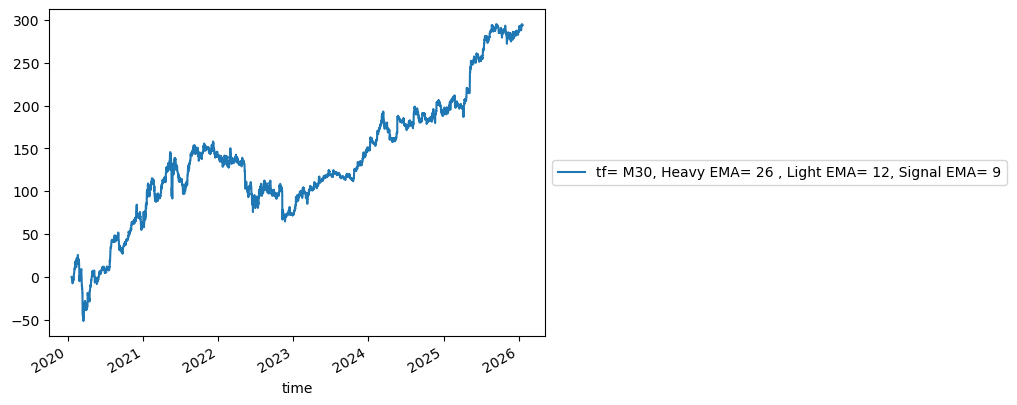

In [5]:
positive_return = 0
negative_return = 0
neutral_return = 0
cutoff = 50 

timeframes= ['M30']
heavy_ema= [26]
light_ema= [12]
signal_ema= [9]

for tf in timeframes:
    for h_ema in heavy_ema:
        for l_ema in light_ema:
            for s_ema in signal_ema:
                df_trades, return_perc= get_macd('ETHUSD', tf, 100, '2020-01-20', heavy_ema= h_ema, light_ema= l_ema, signal_ema= s_ema)

                if return_perc > cutoff:                                                                                         #counts how many operations were positive, negative or neutral depending on a arbitrary cutoff
                    positive_return+= 1
                elif return_perc < (cutoff - 50):
                    negative_return+= 1
                else:
                    neutral_return+= 1

print(f"positives: {positive_return}, negatives: {negative_return}, neutral: {neutral_return}")

plt.legend(loc='center left', bbox_to_anchor=(1,0.5))                                                                        #no labels over the graph
plt.show() 

Strategy (tf= M15, H_EMA= 26 , L_EMA= 12 , S_EMA= 9 ) had a return of 223.01%, with 7694 trades
Strategy (tf= M20, H_EMA= 26 , L_EMA= 12 , S_EMA= 9 ) had a return of 283.34%, with 5656 trades
Strategy (tf= M30, H_EMA= 26 , L_EMA= 12 , S_EMA= 9 ) had a return of 294.02%, with 3714 trades
positives: 3, negatives: 0, neutral: 0


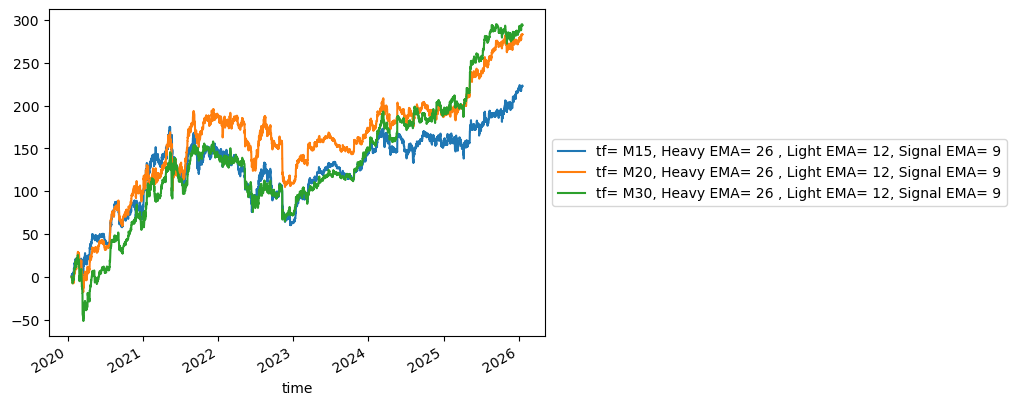

In [142]:
positive_return = 0
negative_return = 0
neutral_return = 0
cutoff = 50 

timeframes= ['M15', 'M20', 'M30']
heavy_ema= [26]
light_ema= [12]
signal_ema= [9]

for tf in timeframes:
    df_trades, return_perc= get_macd('ETHUSD', tf, 100, '2020-01-20')

    if return_perc > cutoff:                                                                                         #counts how many operations were positive, negative or neutral depending on a arbitrary cutoff
        positive_return+= 1
    elif return_perc < (cutoff - 50):
        negative_return+= 1
    else:
        neutral_return+= 1
        
print(f"positives: {positive_return}, negatives: {negative_return}, neutral: {neutral_return}")

plt.legend(loc='center left', bbox_to_anchor=(1,0.5))                                                                        #no labels over the graph
plt.show() 